<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/07_GNN_SchNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SchNet: 3D-aware Neural Networks for Quantum Chemistry

## Table of Contents
0. [Setup and Installation](#setup-and-installation)
1. [Introduction to SchNet](#introduction)
2. [Theoretical Background: 3D-aware Neural Networks](#theoretical-background)
3. [SchNet Architecture in Detail](#schnet-architecture)
4. [Visualizing SchNet Operations](#visualization)
5. [Implementing SchNet for Property Prediction](#implementation)
6. [Visualizing Learned Molecular Representations](#visualize-learned-representation)
7. [Applications and Future Directions](#applications)
8. [Conclusion](#conclusion)

## 0. Setup and Installation <a name="setup-and-installation"></a>

First, let's install the necessary libraries for working with SchNet. We'll need PyTorch, PyTorch Geometric, RDKit for molecular processing, and visualization tools.

In [1]:
#@title Install required packages
import os
import sys
import torch
os.environ['TORCH'] = torch.__version__
print(f"PyTorch version: {torch.__version__}")

# Install PyTorch Geometric and related packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Install visualization and molecular tools
!pip install -q rdkit
!pip install -q plotly

PyTorch version: 2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 51.0 MB/s eta 0:00:00


In [7]:
#@title Import required libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import SchNet
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Optional: Set precision for better numerical stability
torch.set_float32_matmul_precision('high')

Using device: cuda


## 1. Introduction to SchNet <a name="introduction"></a>

### What is SchNet?

SchNet is a deep learning architecture specifically designed for modeling quantum interactions in molecules and materials. Introduced by Schütt et al. in 2017, SchNet extends the capabilities of traditional Graph Neural Networks (GNNs) by incorporating 3D spatial information through continuous-filter convolutional layers.

### Why 3D Information Matters in Molecular Modeling

While traditional GNNs like Graph Convolutional Networks (GCNs) work well for 2D molecular graphs, they have a significant limitation: they don't account for the 3D spatial arrangement of atoms, which is crucial for many molecular properties.

Consider these key differences:

| Traditional GNNs (e.g., GCN) | 3D-aware GNNs (e.g., SchNet) |
|------------------------------|-------------------------------|
| Work with 2D molecular graphs | Consider 3D atomic coordinates |
| Only model bonds as binary connections | Model distance-dependent interactions |
| Cannot distinguish different conformers | Can differentiate molecular conformations |
| Limited for quantum chemistry applications | Suitable for quantum property prediction |

### Key Innovations of SchNet

1. **Continuous-Filter Convolutions**: Unlike discrete grid-based convolutions, SchNet uses continuous filters that can operate on atoms at arbitrary positions in 3D space.

2. **Distance-based Interactions**: SchNet models interactions between atoms based on their interatomic distances, using a set of radial basis functions to provide a rich representation of spatial relationships.


3. **Physics-Informed Design**: SchNet respects fundamental quantum-chemical principles, including:
   - Rotational invariance for energy predictions
   - Translational invariance
   - Energy conservation for force predictions

4. **End-to-End Learning**: SchNet learns representations directly from atomic positions and types, without requiring predefined molecular descriptors or fingerprints.

5. **Versatility**: Can predict various molecular properties, including energies, forces, dipole moments, and more.

SchNet is particularly well-suited for predicting quantum-mechanical properties of molecules such as:

 - **Energies**: Total energy, atomization energy, formation energy
 - **Forces**: Interatomic forces for molecular dynamics simulations
 - **Electronic Properties**: HOMO-LUMO gap, dipole moments
 - **Atomic Properties**: Partial charges, atomic energies

These properties are essential for applications in drug discovery, materials science, and computational chemistry.

## 2. Theoretical Background: 3D-aware Neural Networks <a name="theoretical-background"></a>

### The Challenge of 3D Molecular Data

Molecules exist in 3D space, and their properties are heavily influenced by their spatial configuration. However, typical convolutional neural networks (CNNs) are designed for data on regular grids (like images). Molecular data presents several challenges:

1. **Irregular Spatial Structure**: Atoms can be located anywhere in 3D space, not on a grid
2. **Invariances**: Molecular properties should be invariant to translation and rotation
3. **Equivariances**: Some properties (like forces) should transform predictably with the molecule

### From CNNs to Continuous-Filter Convolutions

Standard 2D CNNs apply discrete filters to data on a grid:

$$(f * k)(x) = \sum_{y \in \Omega} f(y) \cdot k(x - y)$$

Where $f$ is the input, $k$ is the filter, and $\Omega$ is the grid.

SchNet generalizes this to continuous filters that can operate on atoms at arbitrary positions:

$$(f * k)(x) = \int_{\Omega} f(y) \cdot k(x - y) dy$$

In practice, this is implemented as:

$$x_i' = \sum_{j \in \mathcal{N}(i)} x_j \odot W(r_{ij})$$

Where:
- $x_i$ is the feature vector of atom $i$
- $\mathcal{N}(i)$ are the neighbors of atom $i$
- $r_{ij}$ is the distance between atoms $i$ and $j$
- $W(r_{ij})$ is a filter generated based on the distance
- $\odot$ represents element-wise multiplication

### Achieving Physical Invariances

To ensure SchNet respects physical laws:

1. **Rotational Invariance**: Using only distances between atoms (not absolute positions)
2. **Translational Invariance**: Working with relative positions rather than absolute coordinates
3. **Permutation Invariance**: Treating the molecule as a set of atoms, regardless of ordering

Let's visualize how these continuous filters work compared to standard CNNs:

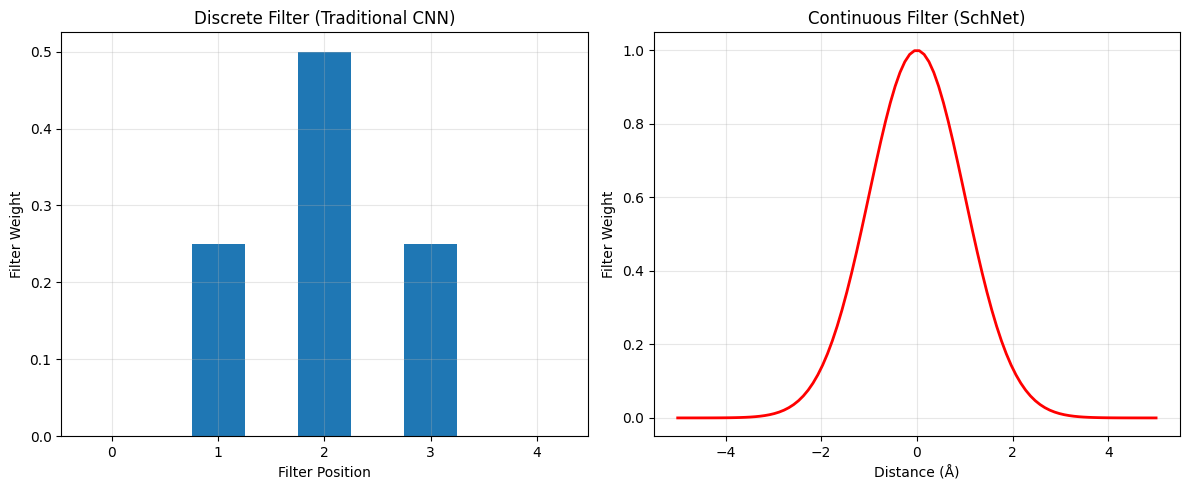

In [5]:
# Visualize the difference between discrete and continuous filters

# Define a 1D discrete filter (like in traditional CNNs)
def discrete_filter(x, filter_width=5):
    filter_values = np.zeros(filter_width)
    center = filter_width // 2
    filter_values[center] = 0.5
    filter_values[center-1] = 0.25
    filter_values[center+1] = 0.25
    return filter_values

# Define a continuous Gaussian filter (like in SchNet)
def continuous_filter(x, sigma=1.0):
    return np.exp(-(x**2) / (2 * sigma**2))

# Create x values for plotting
x_discrete = np.arange(5)
x_continuous = np.linspace(-5, 5, 100)

# Create filters
discrete_f = discrete_filter(x_discrete)
continuous_f = continuous_filter(x_continuous)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot discrete filter
axes[0].bar(x_discrete, discrete_f, width=0.5)
axes[0].set_title('Discrete Filter (Traditional CNN)')
axes[0].set_xlabel('Filter Position')
axes[0].set_ylabel('Filter Weight')
axes[0].grid(True, alpha=0.3)

# Plot continuous filter
axes[1].plot(x_continuous, continuous_f, 'r-', linewidth=2)
axes[1].set_title('Continuous Filter (SchNet)')
axes[1].set_xlabel('Distance (Å)')
axes[1].set_ylabel('Filter Weight')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Let's visualize a more realistic 3D scenario - continuous filters in 3D space
# Create a 3D grid
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
z = np.linspace(-5, 5, 20)
X, Y, Z = np.meshgrid(x, y, z)

# Calculate distances from origin
R = np.sqrt(X**2 + Y**2 + Z**2)

# Compute filter values (Gaussian)
sigma = 2.0
Filter_3D = np.exp(-(R**2) / (2 * sigma**2))

# Create 3D visualization using Plotly for interactivity
fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=Filter_3D.flatten(),
    isomin=0.1,
    isomax=0.8,
    surface_count=5,  # Number of isosurfaces
    colorscale='Viridis',
    opacity=0.6,
    caps=dict(x_show=False, y_show=False, z_show=False)
))

fig.update_layout(
    title='3D Continuous Filter for Molecular Interactions',
    scene=dict(
        xaxis_title='X (Å)',
        yaxis_title='Y (Å)',
        zaxis_title='Z (Å)'
    ),
    width=700,
    height=700,
    margin=dict(t=50, b=10, l=10, r=10)
)

fig.show()

## 3. SchNet Architecture in Detail <a name="schnet-architecture"></a>

SchNet is an end-to-end neural network architecture that learns representations of atoms in molecules based on continuous-filter convolutions. Let's break down its components:

### Overall Architecture

The SchNet architecture consists of three main components:

1. **Atom Embedding**: Maps each atom type to a feature vector
2. **Interaction Blocks**: Learn representations of atoms in their chemical environment
3. **Radial Basis Functions**: Transform interatomic distances into feature vectors
4. **Continuous-filter Convolution**: Applies filters based on interatomic distances
5. **Cutoff Function**: Limits interactions to a local chemical environment
6. **Output Blocks**: Transform atom-wise features to molecular properties


### Key Components

#### 1. Atom Embedding
- Each atom type (C, H, O, N, etc.) is embedded as a learnable vector
- The initial representation only depends on the element type

#### 2. Interaction Blocks
- Series of interaction layers that update atom representations based on their neighbors
- Each block contains:
  - **Continuous-Filter Convolution**: Applies distance-dependent filters to neighboring atoms
  - **Filter-Generating Network**: Creates filters based on interatomic distances
  - **Cutoff Function**: Limits interactions to a local chemical environment

#### 3. Output Networks
- Atom-wise layers transform features to atom-wise properties
- Pooling operations (e.g., sum or mean) aggregate atom features for molecule-level predictions

The core operation in SchNet is the continuous-filter convolution. For each atom $i$, the update rule is:

$$\mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \odot h_{\mathbf{\Theta}} ( \exp(-\gamma(\mathbf{e}_{j,i} - \mathbf{\mu})))$$

Where:
- $\mathbf{x}_j$ are the features of atom $j$
- $\mathcal{N}(i)$ is the neighborhood of atom $i$
- $\mathbf{e}_{j,i}$ is the distance between atoms $j$ and $i$
- $h_{\mathbf{\Theta}}$ is a neural network that generates filter weights
- $\odot$ denotes element-wise multiplication
- $\gamma$ and $\mathbf{\mu}$ are learned parameters


Let's implement a simplified version of the SchNet architecture to understand its key components:

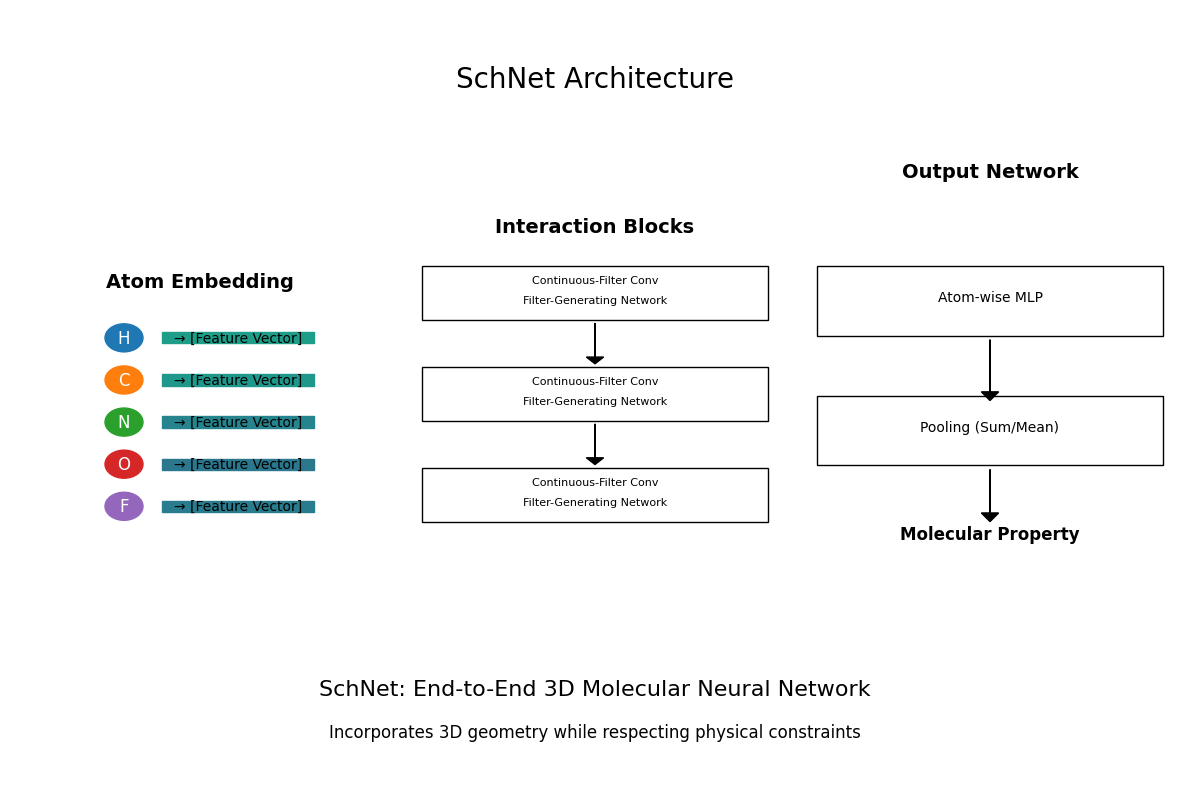

In [14]:
class ShiftedSoftplus(nn.Module):
    """
    Shifted softplus activation function:
    f(x) = ln(1 + e^x) - ln(2)

    Used in SchNet to ensure f(0) = 0
    """
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = np.log(2.0)

    def forward(self, x):
        return F.softplus(x) - self.shift


class GaussianSmearing(nn.Module):
    """
    Gaussian smearing of distances to create distance features.
    """
    def __init__(self, start=0.0, stop=5.0, n_gaussians=50):
        super(GaussianSmearing, self).__init__()
        offset = torch.linspace(start, stop, n_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist):
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))


class CFConvSimplified(nn.Module):
    """
    Simplified continuous-filter convolution layer for SchNet.
    """
    def __init__(self, n_features, n_filters=128):
        super(CFConvSimplified, self).__init__()
        # Filter-generating network
        self.filter_network = nn.Sequential(
            nn.Linear(n_filters, n_features),
            ShiftedSoftplus(),
            nn.Linear(n_features, n_features)
        )

        # Atom-wise layers
        self.conv_layers = nn.Sequential(
            nn.Linear(n_features, n_features),
            ShiftedSoftplus(),
            nn.Linear(n_features, n_features)
        )

    def forward(self, x, dist_expansion, neighbors):
        # Generate filters from distance expansion
        W = self.filter_network(dist_expansion)  # [n_edges, n_features]

        # Get features of neighboring atoms
        neighbor_features = x[neighbors]  # [n_edges, n_features]

        # Apply filter
        neighbor_features = neighbor_features * W  # Element-wise multiplication

        # Aggregate messages from neighbors (simplified)
        aggregated = torch.zeros_like(x)
        for i in range(x.shape[0]):
            mask = neighbors == i
            if mask.any():
                aggregated[i] = neighbor_features[mask].sum(dim=0)

        # Apply atom-wise layers
        return self.conv_layers(aggregated)


class InteractionBlockSimplified(nn.Module):
    """
    Simplified SchNet interaction block.
    """
    def __init__(self, n_features, n_filters=128):
        super(InteractionBlockSimplified, self).__init__()
        self.cfconv = CFConvSimplified(n_features, n_filters)
        self.dense = nn.Linear(n_features, n_features)
        self.activation = ShiftedSoftplus()

    def forward(self, x, dist_expansion, neighbors):
        v = self.cfconv(x, dist_expansion, neighbors)
        v = self.dense(v)
        return x + v  # Residual connection


class SimplifiedSchNet(nn.Module):
    """
    Simplified SchNet model for educational purposes.
    """
    def __init__(self, n_atom_types=100, n_features=128, n_interactions=3, n_filters=128, cutoff=5.0):
        super(SimplifiedSchNet, self).__init__()
        # Atom embedding
        self.embedding = nn.Embedding(n_atom_types, n_features)

        # Distance expansion
        self.distance_expansion = GaussianSmearing(0.0, cutoff, n_filters)

        # Interaction blocks
        self.interactions = nn.ModuleList([
            InteractionBlockSimplified(n_features, n_filters)
            for _ in range(n_interactions)
        ])

        # Output network for energy prediction
        self.output_network = nn.Sequential(
            nn.Linear(n_features, n_features//2),
            ShiftedSoftplus(),
            nn.Linear(n_features//2, 1)
        )

    def forward(self, z, positions, edge_index):
        # Get atom embeddings
        x = self.embedding(z)  # [n_atoms, n_features]

        # Calculate distances
        senders, receivers = edge_index
        dist_vec = positions[senders] - positions[receivers]
        dist = torch.norm(dist_vec, dim=1)

        # Expand distances
        dist_expansion = self.distance_expansion(dist)  # [n_edges, n_filters]

        # Apply interaction blocks
        for interaction in self.interactions:
            x = interaction(x, dist_expansion, receivers)

        # Predict atom-wise energies
        atom_energies = self.output_network(x)  # [n_atoms, 1]

        # Sum to get total energy
        total_energy = atom_energies.sum()

        return total_energy

# Create a diagram of the SchNet architecture
def plot_schnet_architecture():
    # Create a figure with custom layout
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 2, 1])

    # Title
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.text(0.5, 0.5, "SchNet Architecture", fontsize=20, ha='center', va='center')
    ax_title.axis('off')

    # Atom Embedding
    ax_embedding = fig.add_subplot(gs[1, 0])
    ax_embedding.text(0.5, 0.9, "Atom Embedding", fontsize=14, ha='center', va='center', fontweight='bold')

    # Draw atom types
    atom_types = ['H', 'C', 'N', 'O', 'F']
    embeddings = np.random.rand(5, 5)  # Mock embeddings

    # Draw atoms
    y_positions = np.linspace(0.7, 0.1, len(atom_types))
    for i, atom in enumerate(atom_types):
        ax_embedding.add_patch(plt.Circle((0.3, y_positions[i]), 0.05, color=plt.cm.tab10(i)))
        ax_embedding.text(0.3, y_positions[i], atom, fontsize=12, ha='center', va='center', color='white')

        # Draw embedding vector
        ax_embedding.add_patch(plt.Rectangle((0.4, y_positions[i]-0.02), 0.4, 0.04, color=plt.cm.viridis(embeddings[i].mean())))
        ax_embedding.text(0.6, y_positions[i], "→ [Feature Vector]", fontsize=10, ha='center', va='center')

    ax_embedding.axis('off')

    # Interaction Blocks
    ax_interaction = fig.add_subplot(gs[1, 1])
    ax_interaction.text(0.5, 0.9, "Interaction Blocks", fontsize=14, ha='center', va='center', fontweight='bold')

    n_blocks = 3
    y_block_positions = np.linspace(0.7, 0.1, n_blocks)

    for i in range(n_blocks):
        # Draw block
        ax_interaction.add_patch(plt.Rectangle((0.2, y_block_positions[i]-0.08), 0.6, 0.16,
                                               fill=False, edgecolor='black'))

        # Draw components
        ax_interaction.text(0.5, y_block_positions[i]+0.03, "Continuous-Filter Conv", fontsize=8, ha='center')
        ax_interaction.text(0.5, y_block_positions[i]-0.03, "Filter-Generating Network", fontsize=8, ha='center')

        # Draw arrow to next block
        if i < n_blocks-1:
            ax_interaction.arrow(0.5, y_block_positions[i]-0.09, 0, y_block_positions[i+1]-y_block_positions[i]+0.20,
                                head_width=0.03, head_length=0.02, fc='black', ec='black')

    ax_interaction.axis('off')

    # Output Network
    ax_output = fig.add_subplot(gs[1, 2])
    ax_output.text(0.5, 0.9, "Output Network", fontsize=14, ha='center', va='center', fontweight='bold')

    # Draw atom-wise output
    y_out_pos = 0.6
    ax_output.add_patch(plt.Rectangle((0.2, y_out_pos-0.08), 0.6, 0.16, fill=False, edgecolor='black'))
    ax_output.text(0.5, y_out_pos, "Atom-wise MLP", fontsize=10, ha='center')

    # Draw pooling
    y_pool_pos = 0.3
    ax_output.add_patch(plt.Rectangle((0.2, y_pool_pos-0.08), 0.6, 0.16, fill=False, edgecolor='black'))
    ax_output.text(0.5, y_pool_pos, "Pooling (Sum/Mean)", fontsize=10, ha='center')

    # Arrow from atom-wise to pooling
    ax_output.arrow(0.5, y_out_pos-0.09, 0, -0.12, head_width=0.03, head_length=0.02, fc='black', ec='black')

    # Output
    ax_output.text(0.5, 0.05, "Molecular Property", fontsize=12, ha='center', fontweight='bold')
    ax_output.arrow(0.5, y_pool_pos-0.09, 0, -0.1, head_width=0.03, head_length=0.02, fc='black', ec='black')

    ax_output.axis('off')

    # Bottom description
    ax_bottom = fig.add_subplot(gs[2, :])
    ax_bottom.text(0.5, 0.6, "SchNet: End-to-End 3D Molecular Neural Network", fontsize=16, ha='center')
    ax_bottom.text(0.5, 0.3, "Incorporates 3D geometry while respecting physical constraints", fontsize=12, ha='center')
    ax_bottom.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the SchNet architecture
plot_schnet_architecture()

## 4. Visualizing SchNet Operations <a name="visualization"></a>

To better understand how SchNet processes molecular data, let's visualize some of its key operations:

1. **Distance Expansion**: How interatomic distances are transformed into features
2. **Continuous-Filter Convolution**: How atom features are updated based on their neighborhood
3. **Message Passing**: How information flows between atoms during forward passes

### Distance Expansion Visualization

SchNet uses Gaussian smearing to expand interatomic distances into a high-dimensional feature vector. This expansion allows the model to learn complex distance-dependent interactions.

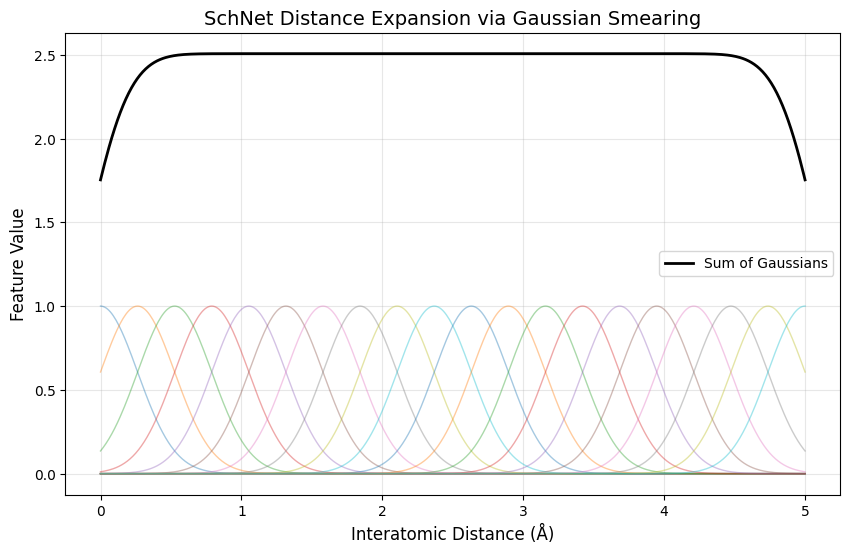

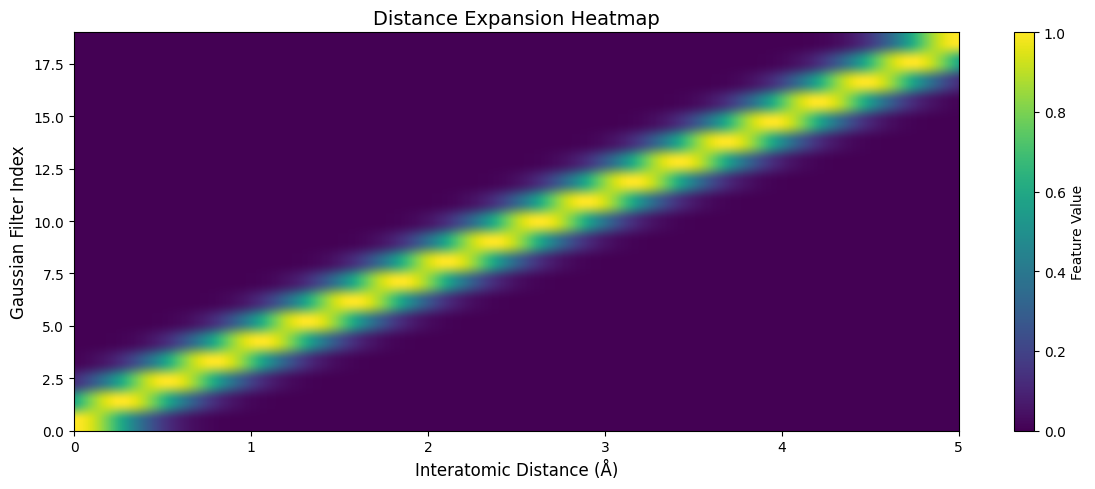

In [16]:
# Visualize distance expansion using Gaussian smearing
def visualize_distance_expansion():
    # Create a range of distances
    distances = np.linspace(0, 5, 500)  # From 0 to 5 Angstroms

    # Create Gaussian smearing module
    n_gaussians = 20
    smearing = GaussianSmearing(0.0, 5.0, n_gaussians)

    # Expand distances
    dist_tensor = torch.tensor(distances, dtype=torch.float32)
    expanded = smearing(dist_tensor).detach().numpy()

    # Create visualization
    plt.figure(figsize=(10, 6))

    # Plot individual Gaussians
    for i in range(n_gaussians):
        plt.plot(distances, expanded[:, i], alpha=0.4, lw=1)

    # Plot sum (to show coverage)
    plt.plot(distances, expanded.sum(axis=1), 'k-', lw=2, label='Sum of Gaussians')

    plt.title('SchNet Distance Expansion via Gaussian Smearing', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Feature Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Heatmap view of the expansion
    plt.figure(figsize=(12, 5))
    plt.imshow(expanded.T, aspect='auto', origin='lower',
               extent=[0, 5, 0, n_gaussians-1], cmap='viridis')
    plt.colorbar(label='Feature Value')
    plt.title('Distance Expansion Heatmap', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Gaussian Filter Index', fontsize=12)
    plt.tight_layout()
    plt.show()

# Let's create a visualization of the distance expansion
visualize_distance_expansion()

### Continuous-Filter Generation Visualization

One of the key innovations of SchNet is its ability to generate filters based on interatomic distances. Let's visualize how these filters look for different distances:

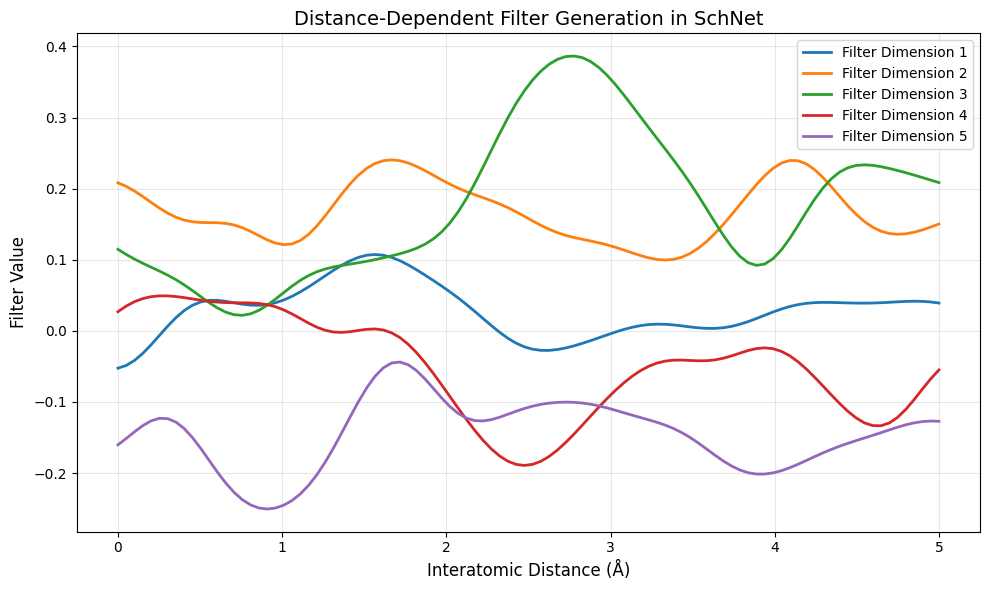

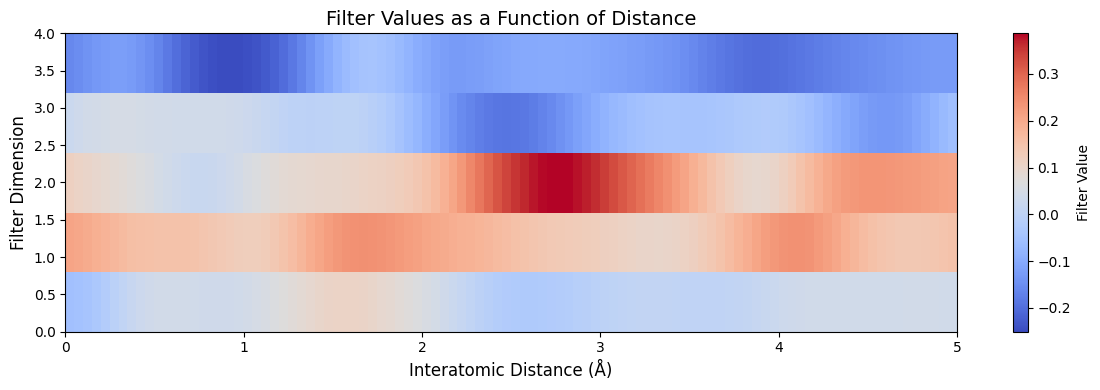

In [17]:
# Implement a simple filter-generating network to visualize
class SimpleFilterNet(nn.Module):
    def __init__(self, n_filters=20, n_out=5):
        super(SimpleFilterNet, self).__init__()
        self.dense1 = nn.Linear(n_filters, 16)
        self.dense2 = nn.Linear(16, n_out)
        self.activation = ShiftedSoftplus()

    def forward(self, x):
        x = self.activation(self.dense1(x))
        return self.dense2(x)

def visualize_filter_generation():
    # Create a range of distances
    distances = np.linspace(0, 5, 100)  # From 0 to 5 Angstroms

    # Initialize modules
    n_gaussians = 20
    n_features = 5
    smearing = GaussianSmearing(0.0, 5.0, n_gaussians)
    filter_net = SimpleFilterNet(n_gaussians, n_features)

    # Generate filters for different distances
    dist_tensor = torch.tensor(distances, dtype=torch.float32)
    expanded = smearing(dist_tensor)
    filters = filter_net(expanded).detach().numpy()

    # Visualize the filters
    plt.figure(figsize=(10, 6))

    for i in range(n_features):
        plt.plot(distances, filters[:, i], lw=2, label=f'Filter Dimension {i+1}')

    plt.title('Distance-Dependent Filter Generation in SchNet', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Filter Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Heatmap view
    plt.figure(figsize=(12, 4))
    plt.imshow(filters.T, aspect='auto', origin='lower',
               extent=[0, 5, 0, n_features-1], cmap='coolwarm')
    plt.colorbar(label='Filter Value')
    plt.title('Filter Values as a Function of Distance', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Filter Dimension', fontsize=12)
    plt.tight_layout()
    plt.show()

# Visualize how continuous filters are generated
visualize_filter_generation()

### Message Passing Visualization

Now let's visualize how information flows between atoms during a SchNet forward pass. For this, we'll create a simple molecule and trace the feature updates through one interaction block:

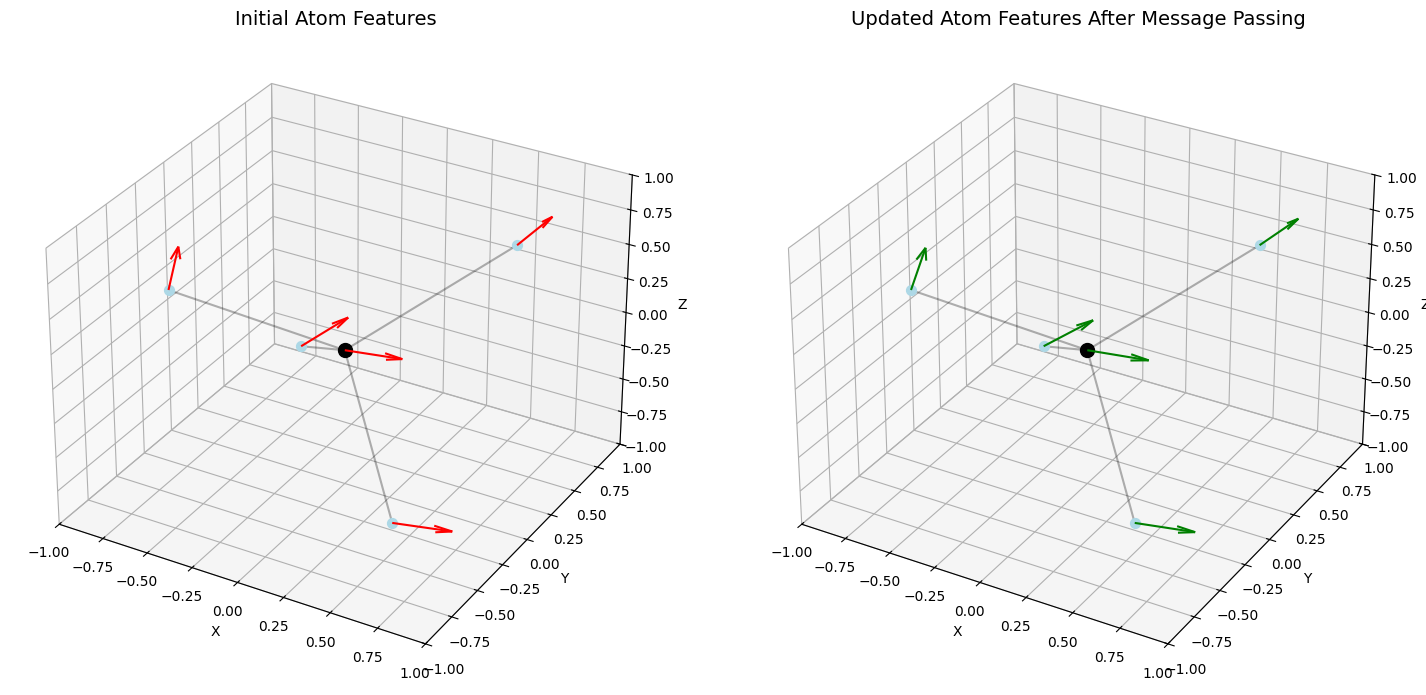

In [18]:
def visualize_message_passing():
    # Create a simple CH4 molecule (methane) - 5 atoms
    n_atoms = 5

    # Mock embedded features - 3D for easy visualization
    features = torch.tensor([
        [1.0, 0.1, 0.1],  # C (center)
        [0.1, 0.8, 0.1],  # H1
        [0.1, 0.1, 0.8],  # H2
        [0.8, 0.1, 0.1],  # H3
        [0.4, 0.4, 0.4],  # H4
    ], dtype=torch.float32)

    # Positions in 3D space (tetrahedral structure)
    positions = torch.tensor([
        [0.0, 0.0, 0.0],          # C at center
        [0.6, 0.6, 0.6],          # H1
        [-0.6, -0.6, 0.6],        # H2
        [0.6, -0.6, -0.6],        # H3
        [-0.6, 0.6, -0.6],        # H4
    ], dtype=torch.float32)

    # Edge list (all hydrogens connected to carbon)
    edge_index = torch.tensor([
        [0, 0, 0, 0, 1, 2, 3, 4],  # Source atoms
        [1, 2, 3, 4, 0, 0, 0, 0]   # Target atoms
    ], dtype=torch.long)

    # Calculate distances
    source, target = edge_index
    distances = torch.norm(positions[source] - positions[target], dim=1)

    # Initialize a simplified message passing mechanism
    n_features = 3  # For visualization simplicity

    # Expand distances (simplified for visualization)
    n_gaussians = 10
    smearing = GaussianSmearing(0.0, 2.0, n_gaussians)
    dist_expanded = smearing(distances)

    # Simple filter network
    filter_net = SimpleFilterNet(n_gaussians, n_features)
    filters = filter_net(dist_expanded)

    # Initial and updated features
    initial_features = features.clone()
    updated_features = torch.zeros_like(features)

    # Perform one step of message passing (simplified)
    for i in range(n_atoms):
        # Find edges where this atom is the target
        mask = (target == i)

        if mask.any():
            # Gather source atoms and their features
            sources = source[mask]

            # Weight source features by filters
            weighted_messages = features[sources] * filters[mask]

            # Sum messages
            updated_features[i] = features[i] + weighted_messages.sum(dim=0)
        else:
            updated_features[i] = features[i]

    # Normalize for visualization
    for i in range(n_atoms):
        norm = torch.norm(updated_features[i])
        if norm > 0:
            updated_features[i] = updated_features[i] / norm

    # Create 3D visualization
    fig = plt.figure(figsize=(15, 7))

    # Original features plot
    ax1 = fig.add_subplot(121, projection='3d')

    # Plot atoms
    atom_colors = ['black', 'lightblue', 'lightblue', 'lightblue', 'lightblue']
    atom_sizes = [100, 50, 50, 50, 50]

    for i in range(n_atoms):
        ax1.scatter(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                   c=atom_colors[i], s=atom_sizes[i], label=f"{'C' if i==0 else 'H'}{i}")

        # Plot feature vector as an arrow
        ax1.quiver(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                  initial_features[i, 0].item(), initial_features[i, 1].item(), initial_features[i, 2].item(),
                  color='red', length=0.3, normalize=True)

    # Plot bonds
    for j in range(4):
        ax1.plot([positions[0, 0].item(), positions[j+1, 0].item()],
                [positions[0, 1].item(), positions[j+1, 1].item()],
                [positions[0, 2].item(), positions[j+1, 2].item()],
                'k-', alpha=0.3)

    ax1.set_title('Initial Atom Features', fontsize=14)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])

    # Updated features plot
    ax2 = fig.add_subplot(122, projection='3d')

    for i in range(n_atoms):
        ax2.scatter(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                   c=atom_colors[i], s=atom_sizes[i])

        # Plot updated feature vector as an arrow
        ax2.quiver(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                  updated_features[i, 0].item(), updated_features[i, 1].item(), updated_features[i, 2].item(),
                  color='green', length=0.3, normalize=True)

    # Plot bonds
    for j in range(4):
        ax2.plot([positions[0, 0].item(), positions[j+1, 0].item()],
                [positions[0, 1].item(), positions[j+1, 1].item()],
                [positions[0, 2].item(), positions[j+1, 2].item()],
                'k-', alpha=0.3)

    ax2.set_title('Updated Atom Features After Message Passing', fontsize=14)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])

    plt.tight_layout()
    plt.show()

    # Create an interactive 3D visualization using Plotly
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        subplot_titles=('Initial Features', 'After Message Passing')
    )

    # Add atoms to both plots
    atom_names = ['C', 'H', 'H', 'H', 'H']
    for i in range(n_atoms):
        # Initial features plot
        fig.add_trace(
            go.Scatter3d(
                x=[positions[i, 0].item()],
                y=[positions[i, 1].item()],
                z=[positions[i, 2].item()],
                mode='markers',
                marker=dict(size=atom_sizes[i]/3, color=atom_colors[i]),
                name=atom_names[i] if i < 2 else None,
                showlegend=i < 2  # Only show legend for first two atoms (C, H)
            ),
            row=1, col=1
        )

        # Updated features plot
        fig.add_trace(
            go.Scatter3d(
                x=[positions[i, 0].item()],
                y=[positions[i, 1].item()],
                z=[positions[i, 2].item()],
                mode='markers',
                marker=dict(size=atom_sizes[i]/3, color=atom_colors[i]),
                name=atom_names[i] if i < 2 else None,
                showlegend=False
            ),
            row=1, col=2
        )

        # Add feature vectors as arrows (initial)
        fig.add_trace(
            go.Scatter3d(
                x=[positions[i, 0].item(), positions[i, 0].item() + 0.3*initial_features[i, 0].item()],
                y=[positions[i, 1].item(), positions[i, 1].item() + 0.3*initial_features[i, 1].item()],
                z=[positions[i, 2].item(), positions[i, 2].item() + 0.3*initial_features[i, 2].item()],
                mode='lines',
                line=dict(color='red', width=5),
                name='Initial Feature' if i == 0 else None,
                showlegend=i == 0
            ),
            row=1, col=1
        )

        # Add feature vectors as arrows (updated)
        fig.add_trace(
            go.Scatter3d(
                x=[positions[i, 0].item(), positions[i, 0].item() + 0.3*updated_features[i, 0].item()],
                y=[positions[i, 1].item(), positions[i, 1].item() + 0.3*updated_features[i, 1].item()],
                z=[positions[i, 2].item(), positions[i, 2].item() + 0.3*updated_features[i, 2].item()],
                mode='lines',
                line=dict(color='green', width=5),
                name='Updated Feature' if i == 0 else None,
                showlegend=i == 0
            ),
            row=1, col=2
        )

    # Add bonds
    for j in range(4):
        # Initial features plot
        fig.add_trace(
            go.Scatter3d(
                x=[positions[0, 0].item(), positions[j+1, 0].item()],
                y=[positions[0, 1].item(), positions[j+1, 1].item()],
                z=[positions[0, 2].item(), positions[j+1, 2].item()],
                mode='lines',
                line=dict(color='black', width=3, dash='dot'),
                name='Bond' if j == 0 else None,
                showlegend=j == 0
            ),
            row=1, col=1
        )

        # Updated features plot
        fig.add_trace(
            go.Scatter3d(
                x=[positions[0, 0].item(), positions[j+1, 0].item()],
                y=[positions[0, 1].item(), positions[j+1, 1].item()],
                z=[positions[0, 2].item(), positions[j+1, 2].item()],
                mode='lines',
                line=dict(color='black', width=3, dash='dot'),
                showlegend=False
            ),
            row=1, col=2
        )

    # Update layout
    fig.update_layout(
        title='SchNet Message Passing Visualization',
        scene1=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',
        ),
        scene2=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',
        ),
        legend=dict(x=0.7, y=0.9),
        width=1000,
        height=500,
    )

    fig.show()

# Run the visualization of message passing in SchNet
visualize_message_passing()

## 5. Implementing SchNet for Property Prediction <a name="implementation"></a>

Now that we understand the SchNet architecture and its key operations, let's implement a full SchNet model for molecular property prediction. We'll use the QM9 dataset, which contains quantum-mechanical properties of small organic molecules.

### The QM9 Dataset

QM9 is a widely used benchmark dataset for molecular property prediction. It contains:

- ~134k small organic molecules with up to 9 heavy atoms (C, O, N, F)
- 12 quantum-mechanical properties computed at the DFT/B3LYP level
- 3D conformations of each molecule

This makes it perfect for training and evaluating SchNet models.

### Training a SchNet Model

Let's use the schnetpack library to set up and train a SchNet model on the QM9 dataset. We'll predict the HOMO-LUMO gap, an important property for electronic applications.

In [20]:
def explore_qm9_dataset():
    """Explore the QM9 dataset."""
    # Download and load QM9 dataset
    # Set small=True to load a subset for faster exploration
    dataset = QM9(root='data/QM9')

    print(f"Dataset size: {len(dataset)} molecules")

    # Examine one molecule
    data = dataset[0]
    print("\nSample molecule data:")
    print(f"Atomic numbers: {data.z}")
    print(f"Positions shape: {data.pos.shape}")
    print(f"Target properties shape: {data.y.shape}")

    # QM9 target properties
    target_names = [
        'dipole moment',
        'isotropic polarizability',
        'HOMO energy',
        'LUMO energy',
        'HOMO-LUMO gap',
        'electronic spatial extent',
        'zero point vibrational energy',
        'internal energy at 0K',
        'internal energy at 298.15K',
        'enthalpy at 298.15K',
        'free energy at 298.15K',
        'heat capacity at 298.15K'
    ]

    print("\nAvailable target properties:")
    for i, name in enumerate(target_names):
        print(f"{i}: {name}")

    return dataset, target_names

# Explore the QM9 dataset
qm9_dataset, target_names = explore_qm9_dataset()

Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [02:26<00:00, 911.80it/s]
Done!


Dataset size: 130831 molecules

Sample molecule data:
Atomic numbers: tensor([6, 1, 1, 1, 1])
Positions shape: torch.Size([5, 3])
Target properties shape: torch.Size([1, 19])

Available target properties:
0: dipole moment
1: isotropic polarizability
2: HOMO energy
3: LUMO energy
4: HOMO-LUMO gap
5: electronic spatial extent
6: zero point vibrational energy
7: internal energy at 0K
8: internal energy at 298.15K
9: enthalpy at 298.15K
10: free energy at 298.15K
11: heat capacity at 298.15K


Loading QM9 dataset...
Target property: HOMO-LUMO gap (index: 4)
Dataset split: 104664 train, 13083 validation, 13084 test

Sample batch:
z shape: torch.Size([575])
pos shape: torch.Size([575, 3])
batch shape: torch.Size([575])
y shape: torch.Size([32, 19])

Target property statistics:
Mean: 6.8585, Std: 1.2842


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning:

It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning:

It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, 


Starting training...
Epoch 1/10: Train Loss: 0.7287, Valid Loss: 0.1373, Train MAE: 0.5660, Valid MAE: 0.3737
Epoch 2/10: Train Loss: 0.1533, Valid Loss: 0.1311, Train MAE: 0.3904, Valid MAE: 0.3741
Epoch 3/10: Train Loss: 0.1063, Valid Loss: 0.1055, Train MAE: 0.3223, Valid MAE: 0.3317
Epoch 4/10: Train Loss: 0.0785, Valid Loss: 0.0643, Train MAE: 0.2753, Valid MAE: 0.2457
Epoch 5/10: Train Loss: 0.0574, Valid Loss: 0.0412, Train MAE: 0.2351, Valid MAE: 0.2011
Epoch 6/10: Train Loss: 0.0449, Valid Loss: 0.0446, Train MAE: 0.2082, Valid MAE: 0.2107
Epoch 7/10: Train Loss: 0.0369, Valid Loss: 0.0289, Train MAE: 0.1889, Valid MAE: 0.1683
Epoch 8/10: Train Loss: 0.0312, Valid Loss: 0.0318, Train MAE: 0.1737, Valid MAE: 0.1762
Epoch 9/10: Train Loss: 0.0276, Valid Loss: 0.0246, Train MAE: 0.1627, Valid MAE: 0.1545
Epoch 10/10: Train Loss: 0.0235, Valid Loss: 0.0258, Train MAE: 0.1500, Valid MAE: 0.1571

Test Results:
Loss: 0.0263
MAE: 0.1562
R²: 0.9736


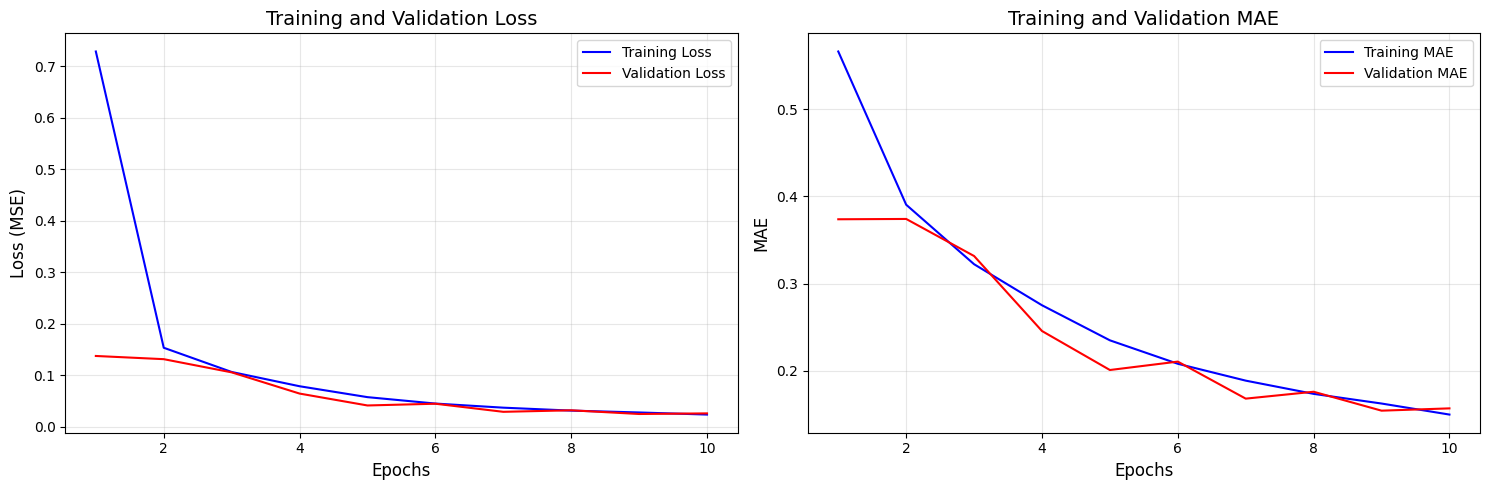

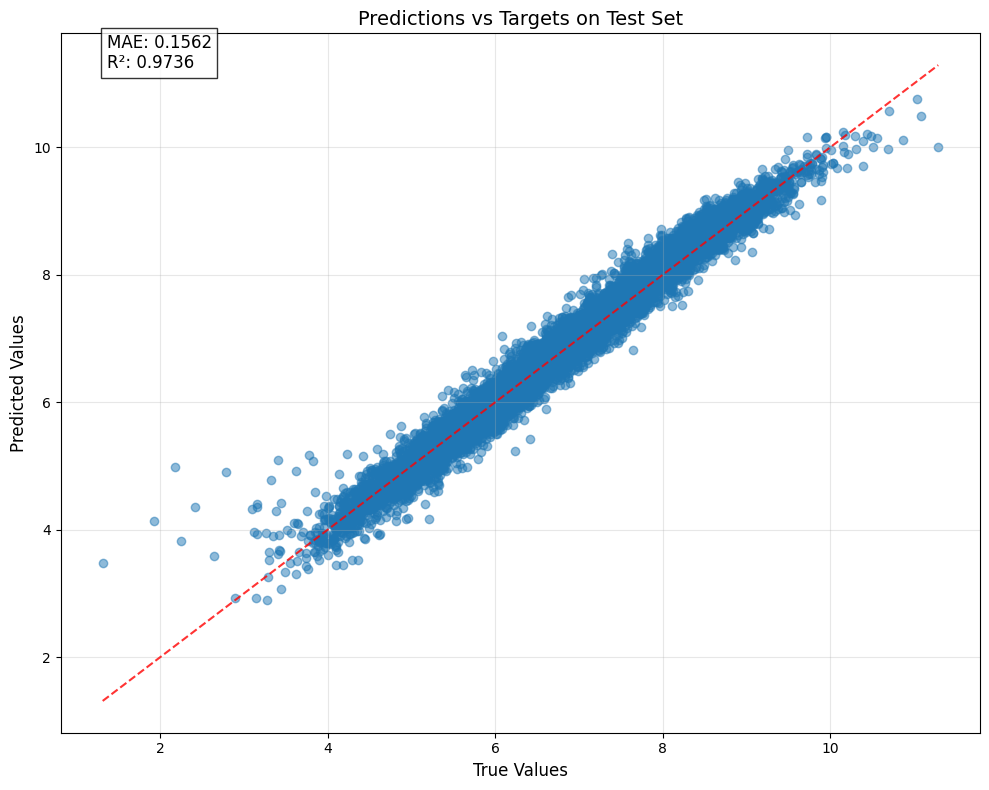

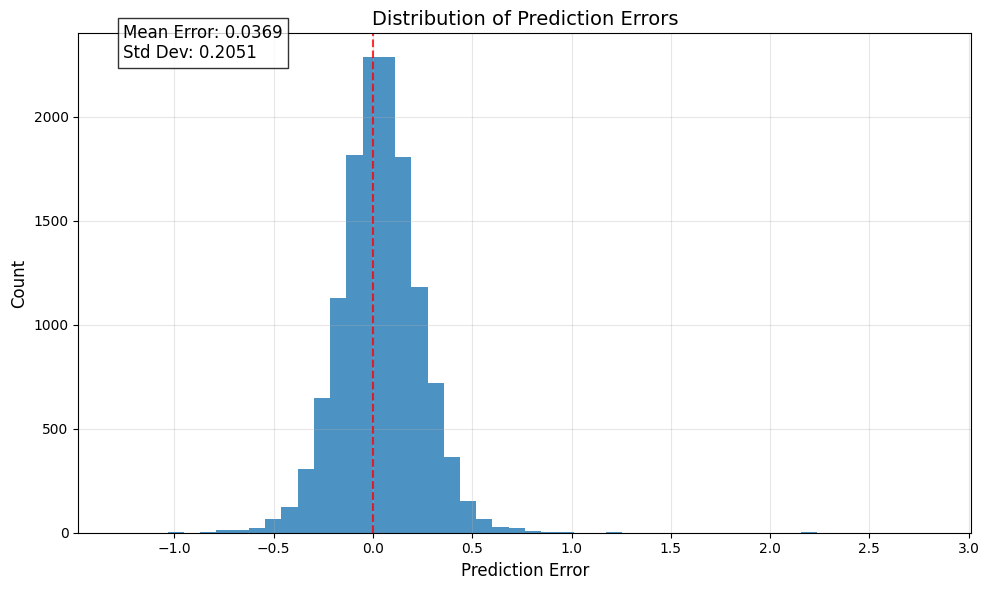

In [21]:
class SchNetForQM9(nn.Module):
    """SchNet model for QM9 property prediction."""
    def __init__(self, hidden_channels=128, num_filters=128, num_interactions=6,
                 num_gaussians=50, cutoff=10.0, target_property=4):
        super(SchNetForQM9, self).__init__()

        self.target_property = target_property

        # Initialize the SchNet model
        self.schnet = SchNet(
            hidden_channels=hidden_channels,
            num_filters=num_filters,
            num_interactions=num_interactions,
            num_gaussians=num_gaussians,
            cutoff=cutoff
        )

    def forward(self, z, pos, batch=None):
        """Forward pass.

        Args:
            z: Atomic numbers [num_atoms]
            pos: Atomic positions [num_atoms, 3]
            batch: Batch assignment for atoms [num_atoms]

        Returns:
            Predicted property
        """
        return self.schnet(z, pos, batch)

#  Training SchNet on QM9 <a name="training"></a>

# Now that we have our model and dataset ready, let's implement the training loop for SchNet on QM9:

def train_schnet_model(target_property=4, batch_size=32, epochs=30, learning_rate=0.0005,
                       hidden_channels=128, num_filters=128, num_interactions=6):
    """Train a SchNet model on QM9 dataset.

    Args:
        target_property: Index of property to predict (default: 4 for HOMO-LUMO gap)
        batch_size: Batch size for training
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        hidden_channels: Hidden embedding size in SchNet
        num_filters: Number of filters in SchNet
        num_interactions: Number of interaction blocks in SchNet

    Returns:
        Trained model and training history
    """
    # Load full QM9 dataset
    print("Loading QM9 dataset...")
    dataset = QM9(root='data/QM9')

    # Get property name for reference
    target_names = [
        'dipole moment',
        'isotropic polarizability',
        'HOMO energy',
        'LUMO energy',
        'HOMO-LUMO gap',
        'electronic spatial extent',
        'zero point vibrational energy',
        'internal energy at 0K',
        'internal energy at 298.15K',
        'enthalpy at 298.15K',
        'free energy at 298.15K',
        'heat capacity at 298.15K'
    ]
    property_name = target_names[target_property]
    print(f"Target property: {property_name} (index: {target_property})")

    # Split dataset into train/validation/test sets (80%/10%/10%)
    train_size = int(0.8 * len(dataset))
    valid_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - valid_size

    # For faster experimentation, we can use a subset
    # Uncomment the following line to use a subset
    # train_size, valid_size, test_size = 1000, 100, 100

    train_dataset, valid_test_dataset = torch.utils.data.random_split(
        dataset, [train_size, valid_size + test_size])
    valid_dataset, test_dataset = torch.utils.data.random_split(
        valid_test_dataset, [valid_size, test_size])

    print(f"Dataset split: {train_size} train, {valid_size} validation, {test_size} test")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Check a single batch
    batch = next(iter(train_loader))
    print(f"\nSample batch:")
    print(f"z shape: {batch.z.shape}")
    print(f"pos shape: {batch.pos.shape}")
    print(f"batch shape: {batch.batch.shape}")
    print(f"y shape: {batch.y.shape}")

    # Compute mean and std of target property for normalization
    mean = dataset.data.y[:, target_property].mean().item()
    std = dataset.data.y[:, target_property].std().item()
    print(f"\nTarget property statistics:")
    print(f"Mean: {mean:.4f}, Std: {std:.4f}")

    # Initialize model
    model = SchNetForQM9(
        hidden_channels=hidden_channels,
        num_filters=num_filters,
        num_interactions=num_interactions,
        target_property=target_property
    ).to(device)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Training history
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_mae': [],
        'valid_mae': []
    }

    # Training loop
    print("\nStarting training...")
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_mae = 0

        for batch in train_loader:
            # Move batch to device
            batch = batch.to(device)

            # Forward pass
            pred = model(batch.z, batch.pos, batch.batch)

            # Target property (normalized)
            target = batch.y[:, target_property].unsqueeze(1)
            target = (target - mean) / std

            # Compute loss
            loss = loss_fn(pred, target)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            train_loss += loss.item() * batch.num_graphs

            # Compute MAE (denormalized)
            pred_denorm = pred * std + mean
            target_denorm = target * std + mean
            mae = torch.abs(pred_denorm - target_denorm).mean().item()
            train_mae += mae * batch.num_graphs

        # Compute average metrics
        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        valid_loss = 0
        valid_mae = 0

        with torch.no_grad():
            for batch in valid_loader:
                # Move batch to device
                batch = batch.to(device)

                # Forward pass
                pred = model(batch.z, batch.pos, batch.batch)

                # Target property (normalized)
                target = batch.y[:, target_property].unsqueeze(1)
                target = (target - mean) / std

                # Compute loss
                loss = loss_fn(pred, target)

                # Accumulate metrics
                valid_loss += loss.item() * batch.num_graphs

                # Compute MAE (denormalized)
                pred_denorm = pred * std + mean
                target_denorm = target * std + mean
                mae = torch.abs(pred_denorm - target_denorm).mean().item()
                valid_mae += mae * batch.num_graphs

        # Compute average metrics
        valid_loss /= len(valid_loader.dataset)
        valid_mae /= len(valid_loader.dataset)

        # Store metrics
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_mae'].append(train_mae)
        history['valid_mae'].append(valid_mae)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, "
              f"Train MAE: {train_mae:.4f}, "
              f"Valid MAE: {valid_mae:.4f}")

    # Final evaluation on test set
    model.eval()
    test_loss = 0
    test_mae = 0
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for batch in test_loader:
            # Move batch to device
            batch = batch.to(device)

            # Forward pass
            pred = model(batch.z, batch.pos, batch.batch)

            # Target property (normalized)
            target = batch.y[:, target_property].unsqueeze(1)
            target = (target - mean) / std

            # Compute loss
            loss = loss_fn(pred, target)

            # Accumulate metrics
            test_loss += loss.item() * batch.num_graphs

            # Compute MAE (denormalized)
            pred_denorm = pred * std + mean
            target_denorm = target * std + mean
            mae = torch.abs(pred_denorm - target_denorm).mean().item()
            test_mae += mae * batch.num_graphs

            # Store predictions and targets for further analysis
            test_preds.extend(pred_denorm.cpu().numpy())
            test_targets.extend(target_denorm.cpu().numpy())

    # Compute average metrics
    test_loss /= len(test_loader.dataset)
    test_mae /= len(test_loader.dataset)

    # Convert to numpy arrays
    test_preds = np.array(test_preds).squeeze()
    test_targets = np.array(test_targets).squeeze()

    # Compute additional metrics
    test_r2 = r2_score(test_targets, test_preds)

    print(f"\nTest Results:")
    print(f"Loss: {test_loss:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")

    # Store test results
    history['test_loss'] = test_loss
    history['test_mae'] = test_mae
    history['test_r2'] = test_r2
    history['test_preds'] = test_preds
    history['test_targets'] = test_targets

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'mean': mean,
        'std': std,
        'target_property': target_property,
        'hidden_channels': hidden_channels,
        'num_filters': num_filters,
        'num_interactions': num_interactions
    }, f'schnet_qm9_prop{target_property}.pt')

    return model, history

# Visualize training results
def plot_training_results(history):
    """Plot training results."""
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['valid_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot training and validation MAE
    ax2.plot(epochs, history['train_mae'], 'b-', label='Training MAE')
    ax2.plot(epochs, history['valid_mae'], 'r-', label='Validation MAE')
    ax2.set_title('Training and Validation MAE', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # If test results are available, plot predictions vs targets
    if 'test_preds' in history and 'test_targets' in history:
        plt.figure(figsize=(10, 8))

        # Plot predictions vs targets
        plt.scatter(history['test_targets'], history['test_preds'], alpha=0.5)

        # Plot the identity line
        min_val = min(history['test_targets'].min(), history['test_preds'].min())
        max_val = max(history['test_targets'].max(), history['test_preds'].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        plt.title('Predictions vs Targets on Test Set', fontsize=14)
        plt.xlabel('True Values', fontsize=12)
        plt.ylabel('Predicted Values', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Add performance metrics as text
        plt.text(0.05, 0.95, f"MAE: {history['test_mae']:.4f}\nR²: {history['test_r2']:.4f}",
                transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Plot distribution of errors
        errors = history['test_preds'] - history['test_targets']
        plt.figure(figsize=(10, 6))

        plt.hist(errors, bins=50, alpha=0.8)
        plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)

        plt.title('Distribution of Prediction Errors', fontsize=14)
        plt.xlabel('Prediction Error', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Add error statistics as text
        plt.text(0.05, 0.95, f"Mean Error: {errors.mean():.4f}\nStd Dev: {errors.std():.4f}",
                transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

# Uncomment the following lines to train the model
# Note: Training can take significant time, especially on CPU
# Target property 4 corresponds to the HOMO-LUMO gap
model, history = train_schnet_model(target_property=4, epochs=10)
plot_training_results(history)

## 6. Visualizing Learned Molecular Representations <a name="visualize-learned-representation"></a>

One of the most powerful aspects of SchNet is its ability to learn meaningful representations of atoms and molecules. Let's visualize these learned representations to gain insights into what the model is learning.

### Atom Embedding Visualization

First, let's visualize the learned atom embeddings to see how SchNet represents different elements:

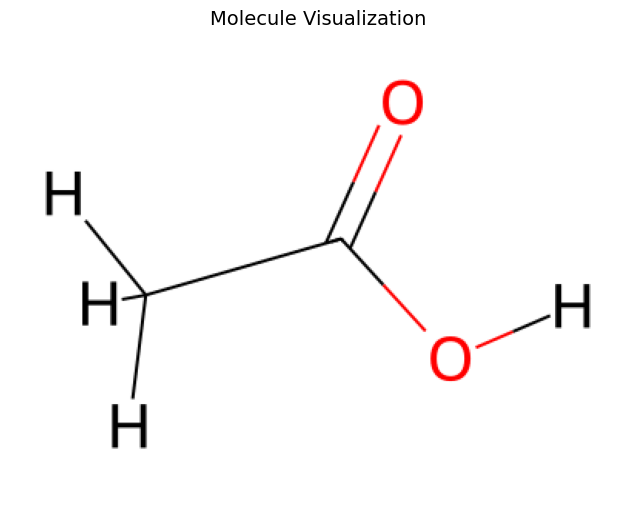

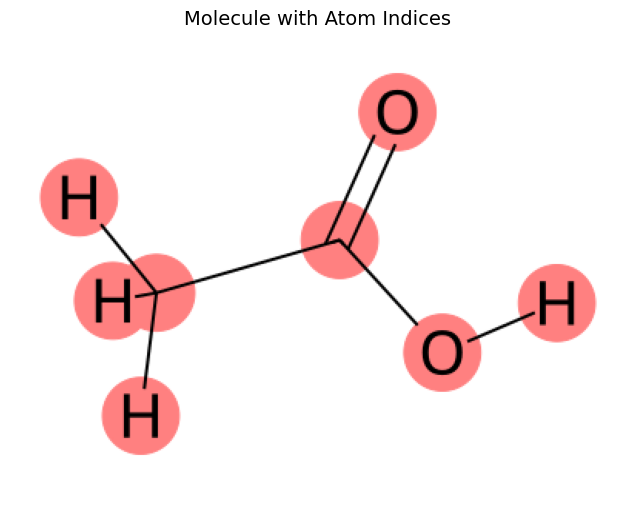

Molecule: CC(=O)O
Atoms: tensor([6, 6, 8, 8, 1, 1, 1, 1])
Positions shape: torch.Size([8, 3])


<ipython-input-23-70d1e1e88833>:82: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-23-70d1e1e88833>:83: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-23-70d1e1e88833>:109: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



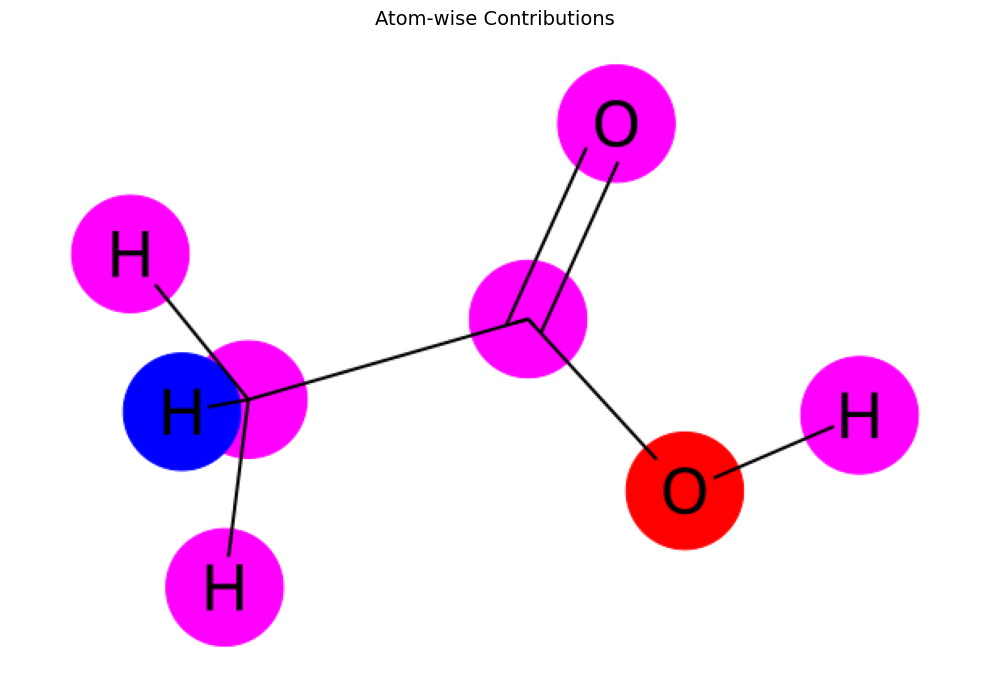

Atom-wise Contributions:


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

def molecule_from_smiles(smiles):
    """Create an RDKit molecule from SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    return mol

def visualize_molecule(mol):
    """Visualize molecule using RDKit."""
    img = Draw.MolToImage(mol, size=(400, 300))
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Molecule Visualization", fontsize=14)
    plt.show()

    # Draw with atom indices
    img = Draw.MolToImage(mol, size=(400, 300), highlightAtoms=range(mol.GetNumAtoms()))
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Molecule with Atom Indices", fontsize=14)
    plt.show()

def extract_atom_contributions(model, z, pos, batch=None):
    """Extract atom-wise contributions from SchNet model."""
    # This function is specific to SchNet implementation
    # It may need to be adapted based on the specific SchNet variant

    # Put model in eval mode
    model.eval()

    # Move data to device
    z = z.to(device)
    pos = pos.to(device)
    if batch is not None:
        batch = batch.to(device)

    # Get the atom embeddings
    with torch.no_grad():
        # Forward pass to get atom embeddings
        if hasattr(model, 'schnet'):
            # For our custom SchNetForQM9 model
            h = model.schnet.embedding(z)

            # Apply interaction blocks
            for interaction in model.schnet.interactions:
                h = h + interaction(h, z, pos, batch)

            # Apply output network to get atom-wise contributions
            atom_contrib = model.schnet.output_network(h)

        else:
            # For the standard PyG SchNet model
            h = model.embedding(z)

            # Apply interaction blocks
            for interaction in model.interactions:
                h = h + interaction(h, z, pos, batch)

            # Apply output network to get atom-wise contributions
            atom_contrib = model.output_network(h)

    return atom_contrib.cpu().numpy()

def visualize_atom_contributions(mol, atom_contrib):
    """Visualize atom-wise contributions in a molecule."""
    # Normalize contributions for visualization
    min_contrib = atom_contrib.min()
    max_contrib = atom_contrib.max()
    norm_contrib = (atom_contrib - min_contrib) / (max_contrib - min_contrib)

    # Create atom highlight colors (red for positive, blue for negative)
    atom_colors = {}
    for i, contrib in enumerate(norm_contrib):
        # Use a colormap (red for high contribution, blue for low)
        r = int(255 * contrib)
        b = int(255 * (1 - contrib))
        atom_colors[i] = (r, 0, b)

    # Draw molecule with atom contributions
    drawer = Draw.MolDraw2DCairo(600, 400)
    Draw.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=range(mol.GetNumAtoms()),
                               highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()

    # Convert to image
    from io import BytesIO
    from PIL import Image
    image = Image.open(BytesIO(img))

    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Atom-wise Contributions", fontsize=14)

    # Add a colorbar
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    # Create a color map
    cmap = cm.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=min_contrib, vmax=max_contrib)

    # Add colorbar
    #plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
    #             label='Atom Contribution', fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Print atom contributions
    print("Atom-wise Contributions:")
    for i, contrib in enumerate(atom_contrib):
        atom = mol.GetAtomWithIdx(i)
        atom_symbol = atom.GetSymbol()
        print(f"Atom {i} ({atom_symbol}): {contrib:.4f}")

    # Create a bar chart of contributions
    plt.figure(figsize=(12, 6))
    atom_symbols = [mol.GetAtomWithIdx(i).GetSymbol() + str(i) for i in range(len(atom_contrib))]

    # Sort by contribution
    sorted_indices = np.argsort(atom_contrib.flatten())
    sorted_contrib = atom_contrib.flatten()[sorted_indices]
    sorted_symbols = [atom_symbols[i] for i in sorted_indices]

    plt.bar(range(len(sorted_contrib)), sorted_contrib)
    plt.xticks(range(len(sorted_contrib)), sorted_symbols, rotation=90)
    plt.xlabel('Atom', fontsize=12)
    plt.ylabel('Contribution', fontsize=12)
    plt.title('Atom-wise Contributions to Prediction', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# Example usage (requires a trained or pre-trained model)
def visualize_atom_contributions_example():
    """Example of visualizing atom contributions for a molecule."""
    # Create a simple molecule
    smiles = "CC(=O)O"  # Acetic acid
    mol = molecule_from_smiles(smiles)
    visualize_molecule(mol)

    # Convert to SchNet input format
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    z = torch.tensor(atoms, dtype=torch.long)

    # Get 3D coordinates
    conf = mol.GetConformer()
    positions = []
    for i in range(mol.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        positions.append([pos.x, pos.y, pos.z])
    pos = torch.tensor(positions, dtype=torch.float)

    print(f"Molecule: {smiles}")
    print(f"Atoms: {z}")
    print(f"Positions shape: {pos.shape}")

    # Assuming we have a trained model, we would do:
    # atom_contrib = extract_atom_contributions(model, z, pos)
    # visualize_atom_contributions(mol, atom_contrib)

    # Since we may not have a trained model, just generate random contributions for demonstration
    atom_contrib = np.random.randn(len(atoms), 1)
    visualize_atom_contributions(mol, atom_contrib)

# Uncomment to run the example
visualize_atom_contributions_example()

### Visualizing SchNet Activations

Let's also visualize the activations within the SchNet model to better understand how it processes molecular information:

Atomic numbers (z): tensor([6, 6, 8, 8, 1, 1, 1, 1]) (type: torch.int64)
Positions: tensor([[-0.9548, -0.0961,  0.0856],
        [ 0.4756,  0.3072, -0.0559],
        [ 0.9032,  1.4445, -0.1505],
        [ 1.3078, -0.7502, -0.0720],
        [-1.2486, -0.7224, -0.7603],
        [-1.5837,  0.7987,  0.0928],
        [-1.0975, -0.6306,  1.0279],
        [ 2.1980, -0.3511, -0.1676]]) (type: torch.float32)
Batch: tensor([0, 0, 0, 0, 0, 0, 0, 0]) (type: torch.int64)
Error visualizing activations: mat1 and mat2 must have the same dtype, but got Long and Float

Debug information:
embedding.weight: shape=torch.Size([100, 64]), dtype=torch.float32
interactions.0.mlp.0.weight: shape=torch.Size([64, 32]), dtype=torch.float32
interactions.0.mlp.0.bias: shape=torch.Size([64]), dtype=torch.float32
interactions.0.mlp.2.weight: shape=torch.Size([64, 64]), dtype=torch.float32
interactions.0.mlp.2.bias: shape=torch.Size([64]), dtype=torch.float32
interactions.0.conv.lin1.weight: shape=torch.Size([64, 64]),

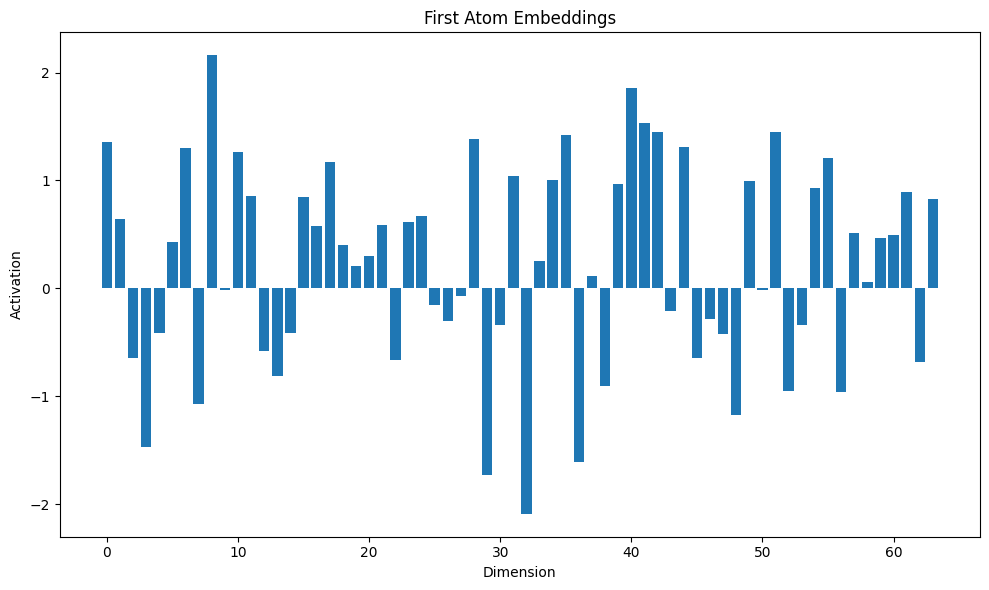

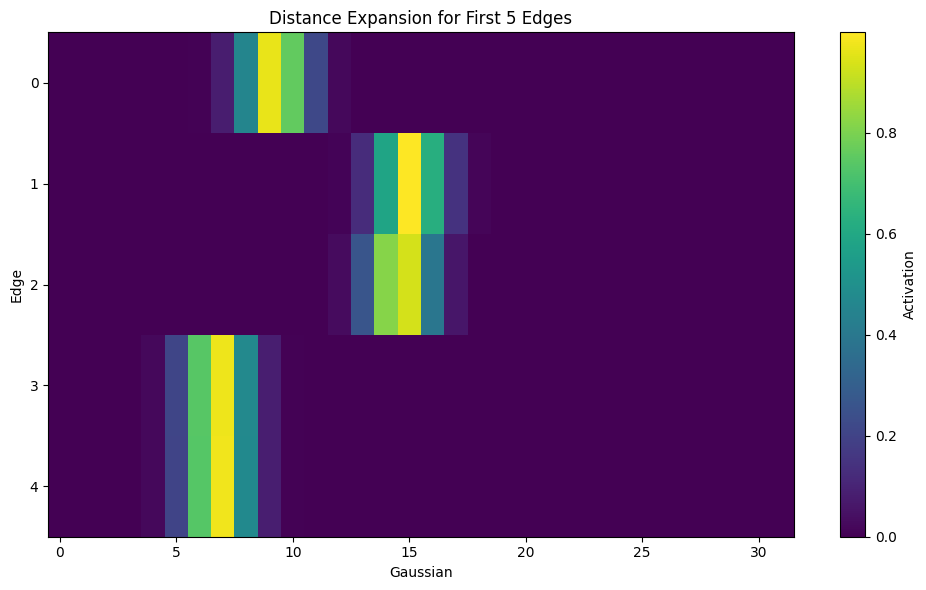

In [30]:
def visualize_schnet_activations(model, z, pos, batch=None):
    """Visualize activations in the SchNet model."""
    # Put model in eval mode
    model.eval()

    # Move data to device
    z = z.to(device)
    pos = pos.to(device)
    if batch is None:
        # If no batch is provided, assume all atoms belong to the same molecule
        batch = torch.zeros_like(z)
    batch = batch.to(device)

    # Container for activations
    activations = []

    # Get initial embeddings
    with torch.no_grad():
        # For the standard PyG SchNet model
        # Get initial atom embeddings
        h = model.embedding(z)
        activations.append(('embedding', h.cpu().numpy()))

        # Get edge index and expand distances using the interaction_graph function
        edge_index, edge_weight = model.interaction_graph(pos, batch)
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)

        # Expand distances
        edge_attr = model.distance_expansion(edge_weight)

        # Apply interaction blocks and collect activations
        for i, interaction in enumerate(model.interactions):
            # In PyG's SchNet, interactions need edge_index and edge_attr
            h = h + interaction(h, edge_index, edge_attr, batch)
            activations.append((f'interaction_{i+1}', h.cpu().numpy()))

        # Final output using the output network
        atom_output = model.output_network(h)
        activations.append(('output', atom_output.cpu().numpy()))

    # Visualize activation statistics
    plt.figure(figsize=(12, 6))

    for i, (name, activation) in enumerate(activations):
        # Compute statistics
        mean_act = np.mean(activation)
        std_act = np.std(activation)
        max_act = np.max(activation)
        min_act = np.min(activation)

        # Plot statistics
        x = i
        plt.plot([x, x], [min_act, max_act], 'k-', alpha=0.3)
        plt.plot(x, mean_act, 'ro', markersize=8)
        plt.plot([x, x], [mean_act - std_act, mean_act + std_act], 'r-', linewidth=2)

    plt.xticks(range(len(activations)), [name for name, _ in activations], rotation=45)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Activation', fontsize=12)
    plt.title('SchNet Activation Statistics Through Layers', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize activation distributions
    plt.figure(figsize=(15, 8))

    for i, (name, activation) in enumerate(activations):
        plt.subplot(2, len(activations)//2 + len(activations)%2, i+1)

        # Flatten activation for histogram
        flat_act = activation.flatten()

        # Plot histogram
        plt.hist(flat_act, bins=30, alpha=0.8)
        plt.title(name, fontsize=10)
        plt.xlabel('Activation', fontsize=8)
        plt.ylabel('Count', fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.suptitle('Activation Distributions Across Layers', fontsize=14, y=1.02)
    plt.show()

    # Visualize activation heatmap for a single atom
    atom_idx = 0  # First atom

    plt.figure(figsize=(12, 6))

    # Extract activation for the selected atom
    atom_activations = np.array([activation[atom_idx] for _, activation in activations])

    # Create heatmap
    plt.imshow(atom_activations, aspect='auto', cmap='viridis')
    plt.colorbar(label='Activation')
    plt.xticks(range(atom_activations.shape[1]), [f'Dim {i+1}' for i in range(atom_activations.shape[1])],
               rotation=90, fontsize=8)
    plt.yticks(range(len(activations)), [name for name, _ in activations])
    plt.title(f'Activations for Atom {atom_idx} Across Layers', fontsize=14)
    plt.tight_layout()
    plt.show()

    return activations

# Example usage (requires a trained or pre-trained model)
def visualize_activations_example():
    """Example of visualizing SchNet activations."""
    # Create a small model for demonstration
    model = SchNet(
        hidden_channels=64,  # Smaller for visualization
        num_filters=64,
        num_interactions=3,  # Fewer interactions for clarity
        num_gaussians=32,
        cutoff=5.0
    ).to(device)

    # Create a simple molecule
    smiles = "CC(=O)O"  # Acetic acid
    mol = molecule_from_smiles(smiles)

    # Convert to SchNet input format
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    # Convert to long tensor for atomic numbers
    z = torch.tensor(atoms, dtype=torch.long)

    # Get 3D coordinates
    conf = mol.GetConformer()
    positions = []
    for i in range(mol.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        positions.append([pos.x, pos.y, pos.z])
    # Convert to float tensor for positions
    pos = torch.tensor(positions, dtype=torch.float32)

    # Create batch indices (all atoms belong to the same molecule)
    batch = torch.zeros(len(atoms), dtype=torch.long)

    print(f"Atomic numbers (z): {z} (type: {z.dtype})")
    print(f"Positions: {pos} (type: {pos.dtype})")
    print(f"Batch: {batch} (type: {batch.dtype})")

    # Visualize activations
    try:
        activations = visualize_schnet_activations(model, z, pos, batch)
        return activations
    except Exception as e:
        print(f"Error visualizing activations: {e}")

        # Let's print more debug information
        print("\nDebug information:")
        for name, param in model.named_parameters():
            print(f"{name}: shape={param.shape}, dtype={param.dtype}")

        # Let's try to run the model directly to see where it fails
        print("\nTrying direct forward pass...")
        try:
            model.eval()
            with torch.no_grad():
                edge_index, edge_weight = model.interaction_graph(pos, batch)
                print(f"Edge index: {edge_index.shape}, dtype={edge_index.dtype}")
                print(f"Edge weight: {edge_weight.shape}, dtype={edge_weight.dtype}")

                # Get initial embeddings
                h = model.embedding(z)
                print(f"Embeddings: {h.shape}, dtype={h.dtype}")

                # Try first interaction
                edge_attr = model.distance_expansion(edge_weight)
                print(f"Edge attr: {edge_attr.shape}, dtype={edge_attr.dtype}")

                h_out = model.interactions[0](h, edge_index, edge_attr, batch)
                print(f"After interaction: {h_out.shape}, dtype={h_out.dtype}")

                print("Forward pass successful!")
        except Exception as e:
            print(f"Error in forward pass: {e}")

            # Let's try a simpler approach with more type conversions
            print("\nAttempting with explicit type conversions...")
            try:
                # Create a simplified visualization function just for this example
                def simple_visualization():
                    model.eval()
                    with torch.no_grad():
                        # Get atom embeddings (ensure long type)
                        z_long = z.long().to(device)
                        h = model.embedding(z_long)
                        print(f"Embeddings: {h.shape}, dtype={h.dtype}")

                        # Compute interaction graph
                        pos_float = pos.float().to(device)
                        batch_long = batch.long().to(device)
                        edge_index, edge_weight = model.interaction_graph(pos_float, batch_long)
                        edge_index = edge_index.to(device)
                        edge_weight = edge_weight.to(device)

                        # Apply distance expansion
                        edge_attr = model.distance_expansion(edge_weight)

                        # Show first layer activation
                        print(f"First layer activation shape: {h.shape}")
                        h_numpy = h.cpu().numpy()
                        plt.figure(figsize=(10, 6))
                        plt.bar(range(h_numpy.shape[1]), h_numpy[0])
                        plt.title("First Atom Embeddings")
                        plt.xlabel("Dimension")
                        plt.ylabel("Activation")
                        plt.tight_layout()
                        plt.show()

                        # Show distance expansion
                        edge_attr_numpy = edge_attr.cpu().numpy()
                        plt.figure(figsize=(10, 6))
                        plt.imshow(edge_attr_numpy[:5], aspect='auto', cmap='viridis')
                        plt.title("Distance Expansion for First 5 Edges")
                        plt.xlabel("Gaussian")
                        plt.ylabel("Edge")
                        plt.colorbar(label="Activation")
                        plt.tight_layout()
                        plt.show()

                        return h_numpy

                # Run the simplified visualization
                simple_visualization()
            except Exception as e:
                print(f"Error in simplified visualization: {e}")

# Uncomment to run the example
visualize_activations_example()


## 7. Applications and Future Directions <a name="applications"></a>

SchNet has demonstrated impressive success in a variety of quantum chemistry and materials science applications. In this section, we'll explore some of the key applications and future directions for 3D-aware neural networks like SchNet.

### Current Applications

#### 1. Quantum Chemistry

SchNet has been particularly successful in predicting quantum-mechanical properties:

- **Molecular Energies**: Prediction of ground state energies and formation energies
- **Force Fields**: Learning accurate interatomic forces for molecular dynamics simulations
- **Electron Densities**: Mapping the electron density distribution within molecules
- **HOMO-LUMO Gaps**: Predicting electronic properties relevant for optoelectronic applications

#### 2. Materials Science

Beyond molecules, SchNet has been applied to materials science problems:

- **Crystal Properties**: Predicting properties of crystalline materials
- **Phase Transitions**: Understanding phase changes in materials
- **Defect Energetics**: Modeling defects in crystal structures
- **Surface Chemistry**: Studying surface reactions and catalysis

#### 3. Drug Discovery

SchNet's ability to model 3D molecular structures makes it valuable for pharmaceutical applications:

- **Binding Affinity Prediction**: Estimating how strongly a molecule will bind to a target protein
- **Drug Property Prediction**: ADMET (Absorption, Distribution, Metabolism, Excretion, Toxicity) predictions
- **Molecular Generation**: Generating molecules with desired properties (when combined with generative models)

### Advantages of SchNet Over Traditional Approaches

Let's compare SchNet with traditional methods in computational chemistry:

In [27]:
# Create a comparison table of SchNet vs traditional methods
comparison_data = {
    'Method': ['Traditional Force Fields', 'Density Functional Theory (DFT)', 'SchNet'],
    'Accuracy': ['Moderate (relies on parameterization)', 'High (first principles)', 'High (learns from DFT data)'],
    'Computational Cost': ['Low (seconds to minutes)', 'High (hours to days)', 'Low after training (milliseconds)'],
    'Transferability': ['Limited to parameterized systems', 'Universal but expensive', 'Good within chemical space of training data'],
    'Scale': ['Millions of atoms', 'Hundreds of atoms', 'Thousands of atoms'],
    '3D Awareness': ['Yes (explicit modeling)', 'Yes (quantum mechanical)', 'Yes (learned representation)'],
    'Chemical Flexibility': ['Limited by force field type', 'Universal', 'Depends on training data diversity']
}

# Create a DataFrame for visualization
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)

# Display the table
comparison_df.style.hide(axis='index')

Method,Accuracy,Computational Cost,Transferability,Scale,3D Awareness,Chemical Flexibility
Traditional Force Fields,Moderate (relies on parameterization),Low (seconds to minutes),Limited to parameterized systems,Millions of atoms,Yes (explicit modeling),Limited by force field type
Density Functional Theory (DFT),High (first principles),High (hours to days),Universal but expensive,Hundreds of atoms,Yes (quantum mechanical),Universal
SchNet,High (learns from DFT data),Low after training (milliseconds),Good within chemical space of training data,Thousands of atoms,Yes (learned representation),Depends on training data diversity


### Future Directions and Challenges

While SchNet has made significant advances, several challenges and opportunities remain for 3D-aware molecular neural networks:

#### 1. Enhanced Architectures

**Current Developments:**

- **DimeNet**: Adds directional information by incorporating angular features (bond angles)
- **GemNet**: Further extends to include 3-body and 4-body interactions
- **Equivariant Networks**: SO(3)-equivariant models that respect rotational symmetry by design
- **Transformers for Molecules**: Applying attention mechanisms to molecular modeling

#### 2. Data Efficiency

- **Active Learning**: Strategically selecting which molecules to compute DFT data for
- **Transfer Learning**: Leveraging models trained on similar tasks or datasets
- **Semi-supervised Approaches**: Combining labeled and unlabeled data
- **Multi-fidelity Learning**: Combining data from different levels of theory

#### 3. Broader Applications

- **Reaction Prediction**: Modeling chemical reactions and transition states
- **Excited States**: Going beyond ground state properties to excited state modeling
- **Multi-scale Modeling**: Bridging quantum, molecular, and mesoscale modeling
- **Non-equilibrium Dynamics**: Modeling systems away from equilibrium

#### 4. Interpretability and Explainability

- **Attribution Methods**: Understanding which parts of a molecule contribute to predictions
- **Feature Importance**: Identifying which 3D features drive molecular properties
- **Uncertainty Quantification**: Providing confidence estimates with predictions
- **Physics-informed Models**: Incorporating known physical laws into neural architectures

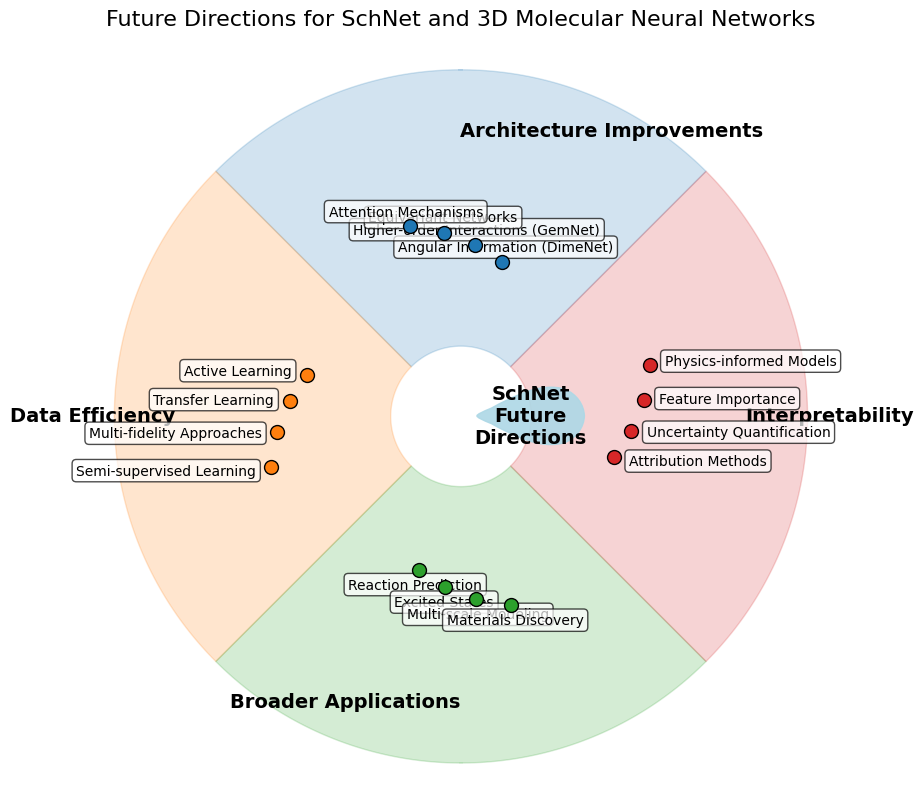

In [28]:
# Create a visualization of future directions for SchNet
def plot_future_directions():
    # Create a figure
    plt.figure(figsize=(12, 8))

    # Define main areas and specific directions
    areas = [
        'Architecture Improvements',
        'Data Efficiency',
        'Broader Applications',
        'Interpretability'
    ]

    specific_directions = {
        'Architecture Improvements': [
            'Angular Information (DimeNet)',
            'Higher-order Interactions (GemNet)',
            'Equivariant Networks',
            'Attention Mechanisms'
        ],
        'Data Efficiency': [
            'Active Learning',
            'Transfer Learning',
            'Multi-fidelity Approaches',
            'Semi-supervised Learning'
        ],
        'Broader Applications': [
            'Reaction Prediction',
            'Excited States',
            'Multi-scale Modeling',
            'Materials Discovery'
        ],
        'Interpretability': [
            'Attribution Methods',
            'Uncertainty Quantification',
            'Feature Importance',
            'Physics-informed Models'
        ]
    }

    # Calculate positions
    n_areas = len(areas)
    angles = np.linspace(0, 2*np.pi, n_areas, endpoint=False)

    # Adjust angles to start from the top
    angles = angles + np.pi/2

    # Plot the areas
    ax = plt.subplot(111, polar=True)

    # Plot the circular segments for main areas
    for i, area in enumerate(areas):
        start_angle = angles[i] - np.pi/n_areas
        end_angle = angles[i] + np.pi/n_areas

        # Create a colored segment
        theta = np.linspace(start_angle, end_angle, 100)
        radii = np.ones_like(theta) * 1.8

        # Plot the segment with transparency
        ax.fill_between(theta, 0, radii, alpha=0.2, color=f"C{i}")

        # Add the area label
        angle = angles[i]
        x = 1.4 * np.cos(angle)
        y = 1.4 * np.sin(angle)
        ha = 'center'
        if np.cos(angle) < 0:
            ha = 'right'
        elif np.cos(angle) > 0:
            ha = 'left'
        plt.text(angle, 1.4, area, ha=ha, va='center', fontsize=14, fontweight='bold')

        # Add specific directions
        for j, direction in enumerate(specific_directions[area]):
            # Calculate position
            inner_radius = 0.5
            radius = inner_radius + (0.9 - inner_radius) * ((j + 1) / (len(specific_directions[area]) + 1))

            # Adjust angle slightly for better spacing
            dir_angle = angle - np.pi/12 + (j * np.pi/6) / (len(specific_directions[area]) - 1)

            x = radius * np.cos(dir_angle)
            y = radius * np.sin(dir_angle)

            # Add a point
            ax.scatter(dir_angle, radius, s=100, color=f"C{i}", edgecolor='black', zorder=10)

            # Add the direction label
            text_radius = radius + 0.1
            ha = 'center'
            if np.cos(dir_angle) < -0.3:
                ha = 'right'
            elif np.cos(dir_angle) > 0.3:
                ha = 'left'
            plt.text(dir_angle, text_radius, direction, ha=ha, va='center', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

    # Add SchNet in the center
    circle = plt.Circle((0, 0), 0.35, color='lightblue', alpha=0.9)
    ax.add_patch(circle)
    plt.text(0, 0, 'SchNet\nFuture\nDirections', ha='center', va='center', fontsize=14, fontweight='bold')

    # Remove unnecessary elements
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(False)

    plt.title('Future Directions for SchNet and 3D Molecular Neural Networks', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Visualize future directions
plot_future_directions()

## 8. Conclusion <a name="conclusion"></a>

In this tutorial, we've explored SchNet, a pioneering deep learning architecture for 3D molecular modeling. Let's summarize what we've learned:

### Key Takeaways

1. **3D Information is Critical**: Unlike traditional GNNs, SchNet incorporates 3D atomic coordinates, enabling more accurate predictions of quantum-mechanical properties.

2. **Continuous-Filter Convolutions**: SchNet uses continuous-filter convolutions to operate on arbitrary atom positions, generalizing CNNs to molecular data.

3. **Physics-Informed Design**: By respecting physical symmetries (rotational, translational, and permutation invariance), SchNet makes predictions that follow fundamental physical laws.

4. **End-to-End Learning**: SchNet learns directly from atomic positions and types, without requiring predefined molecular descriptors or fingerprints.

5. **Interpretability**: The model enables visualization of atomic contributions (local chemical potentials), providing insights into how different parts of a molecule contribute to its properties.

### Practical Implications

SchNet and similar 3D-aware neural networks have several practical implications for chemistry and materials science:

- **Accelerating Quantum Chemistry**: Predictions in milliseconds that would take hours or days with traditional DFT calculations
- **Exploring Chemical Space**: Efficiently screening millions of candidate molecules for desired properties
- **Accurate Force Fields**: Creating ML-based force fields that approach quantum accuracy at classical computational cost
- **Structure-Property Relationships**: Gaining new insights into how 3D structure influences molecular properties

### Getting Started with SchNet

If you're interested in applying SchNet to your own research, here are some resources to get started:

- **SchNetPack**: The official implementation of SchNet - https://github.com/atomistic-machine-learning/schnetpack
- **QM9 Dataset**: A standard benchmark dataset for molecular property prediction - https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904
- **PyTorch Geometric**: Offers implementations of various GNNs including SchNet - https://pytorch-geometric.readthedocs.io/

### Final Thoughts

SchNet represents an important paradigm shift in molecular modeling, demonstrating how deep learning can complement and potentially transform quantum chemistry. It bridges the gap between data-driven approaches and physical understanding, paving the way for more accurate, efficient, and insightful molecular modeling.

As the field continues to advance, we can expect 3D-aware neural networks to play an increasingly important role in drug discovery, materials design, and fundamental chemical research.